# Figure 1

In [8]:
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean.cm as cmo

import ppe_plot as ppeplot
import ppe_load as ppeload
import ppe_analyze as ppealyz

%load_ext watermark
%watermark -iv

sys       : 3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:40:35) [GCC 12.3.0]
matplotlib: 3.8.0
cartopy   : 0.22.0
numpy     : 1.24.4
cmocean   : 3.0.3
xarray    : 2023.10.1



In [5]:
# Get plotting settings
ppeplot.setup_plotting_workspace()

## Load model output

In [6]:
# Get area weights
cesm_weights = xr.open_dataset("/glade/work/bbuchovecky/PPE_analysis/weights/COUP_PPE_weights_atmgrid.nc").rename({"globweights": "globalweights"})
assert cesm_weights.landweights.sum(dim=["lat", "lon"]) == 1

hadcm_weights = xr.open_dataset('/glade/work/bbuchovecky/HadCM3_analysis/weights/HadCM3_weights_v2.nc')
assert hadcm_weights.landweights.sum(dim=["lat", "lon"]) == 1

# Identify variables to load
varlist = ["T_S", "P", "ET"]

# Load time-mean variables
cesm_ppe, cesm_std = ppeload.get_cesm(varlist, "time_mean")
hadhst_ppe, hadhst_std = ppeload.get_hadcm(varlist, "control", "time_mean")
hada1b_ppe, hada1b_std = ppeload.get_hadcm(varlist, "a1b", "time_mean")
dict_cmip_co2, dict_cmip_pi, dict_cmip_weights = ppeload.get_cmip(varlist, "time_mean")

# Store list of CMIP model names
cmip_models = list(dict_cmip_co2.keys())

# Interpolate CMIP variables to a common grid
dlat = 1.90
dlon = 2.50
new_lat = np.arange(-90, 90+dlat, dlat)
new_lon = np.arange(0, 360, dlon)

cmip_landfrac = dict_cmip_weights['CESM2']['landfrac'].interp(lon=new_lon, lat=new_lat, method='linear')

cmip_co2 = dict()
cmip_pi = dict()

for v in varlist:
    co2_list = []
    pi_list = []

    for m in cmip_models:
        co2_list.append(dict_cmip_co2[m][v].interp(lon=new_lon, lat=new_lat, method='linear'))
        pi_list.append(dict_cmip_pi[m][v].interp(lon=new_lon, lat=new_lat, method='linear'))
    
    cmip_co2[v] = xr.concat(co2_list, dim='model', coords='minimal', compat='override').assign_coords(model=("model", np.arange(7)), model_name=("model", cmip_models))
    cmip_pi[v] = xr.concat(pi_list, dim='model', coords='minimal', compat='override').assign_coords(model=np.arange(7), model_name=("model", cmip_models))

# Compute the delta (perturbed - control)
cesm_delta = dict()
hadhst_delta = dict()
hada1b_delta = dict()
cmip_delta = dict()

for v in varlist:
    cesm_delta[v] = cesm_ppe[v] - cesm_std[v]
    hadhst_delta[v] = hadhst_ppe[v] - hadhst_std[v]
    hada1b_delta[v] = hada1b_ppe[v] - hada1b_std[v]
    cmip_delta[v] = cmip_co2[v] - cmip_pi[v]

    cmip_delta[v] = cmip_delta[v].stack(member=['model', 'experiment'])

# Compute the land and ocean mean
cesm_delta_areamean = dict()
hadhst_delta_areamean = dict()
hada1b_delta_areamean = dict()
cmip_delta_areamean = dict()

for w, weight in zip(["lm", "om"], ["landweights", "oceanweights"]):
    try:
        cesm_delta_areamean[w];
        hadhst_delta_areamean[w];
        hada1b_delta_areamean[w];
        cmip_delta_areamean[w];
    except KeyError:
        cesm_delta_areamean[w] = dict()
        hadhst_delta_areamean[w] = dict()
        hada1b_delta_areamean[w] = dict()
        cmip_delta_areamean[w] = dict()

    assert np.round(cesm_weights[weight].sum(), 3) == 1.
    assert np.round(hadcm_weights[weight].sum(), 3) == 1.

    for v in varlist:
        cesm_delta_areamean[w][v] = cesm_delta[v].weighted(cesm_weights[weight]).mean(dim=["lat", "lon"])
        hadhst_delta_areamean[w][v] = hadhst_delta[v].weighted(hadcm_weights[weight]).mean(dim=["lat", "lon"])
        hada1b_delta_areamean[w][v] = hada1b_delta[v].weighted(hadcm_weights[weight]).mean(dim=["lat", "lon"])

        cmip_list = []
        for m in cmip_models:
            assert np.round(dict_cmip_weights[m][weight].sum(), 3) == 1.
            co2 = dict_cmip_co2[m][v].weighted(dict_cmip_weights[m][weight]).mean(dim=["lat", "lon"])
            pi = dict_cmip_pi[m][v].weighted(dict_cmip_weights[m][weight]).mean(dim=["lat", "lon"])
            cmip_list.append(co2 - pi)
        cmip_delta_areamean[w][v] = xr.concat(cmip_list, dim='model', coords='minimal', compat='override').assign_coords(model=("model", np.arange(7)), model_name=("model", cmip_models)).stack(member=['model', 'experiment'])

CESM2 time_mean:
  T_S
  P
  ET
HadCM3 control time_mean:
  T_S
  P
  ET
HadCM3 a1b time_mean:
  T_S
  P
  ET
CMIP6 time_mean:
  CESM2 -- T_S, P, ET, 
  CanESM5 -- T_S, P, ET, 
  GISS-E2-1-G -- T_S, P, ET, 
  HadGEM3-GC31-LL -- T_S, P, ET, 
  IPSL-CM6A-LR -- T_S, P, ET, 
  MIROC6 -- T_S, P, ET, 
  MRI-ESM2-0 -- T_S, P, ET, 



## Create the figure

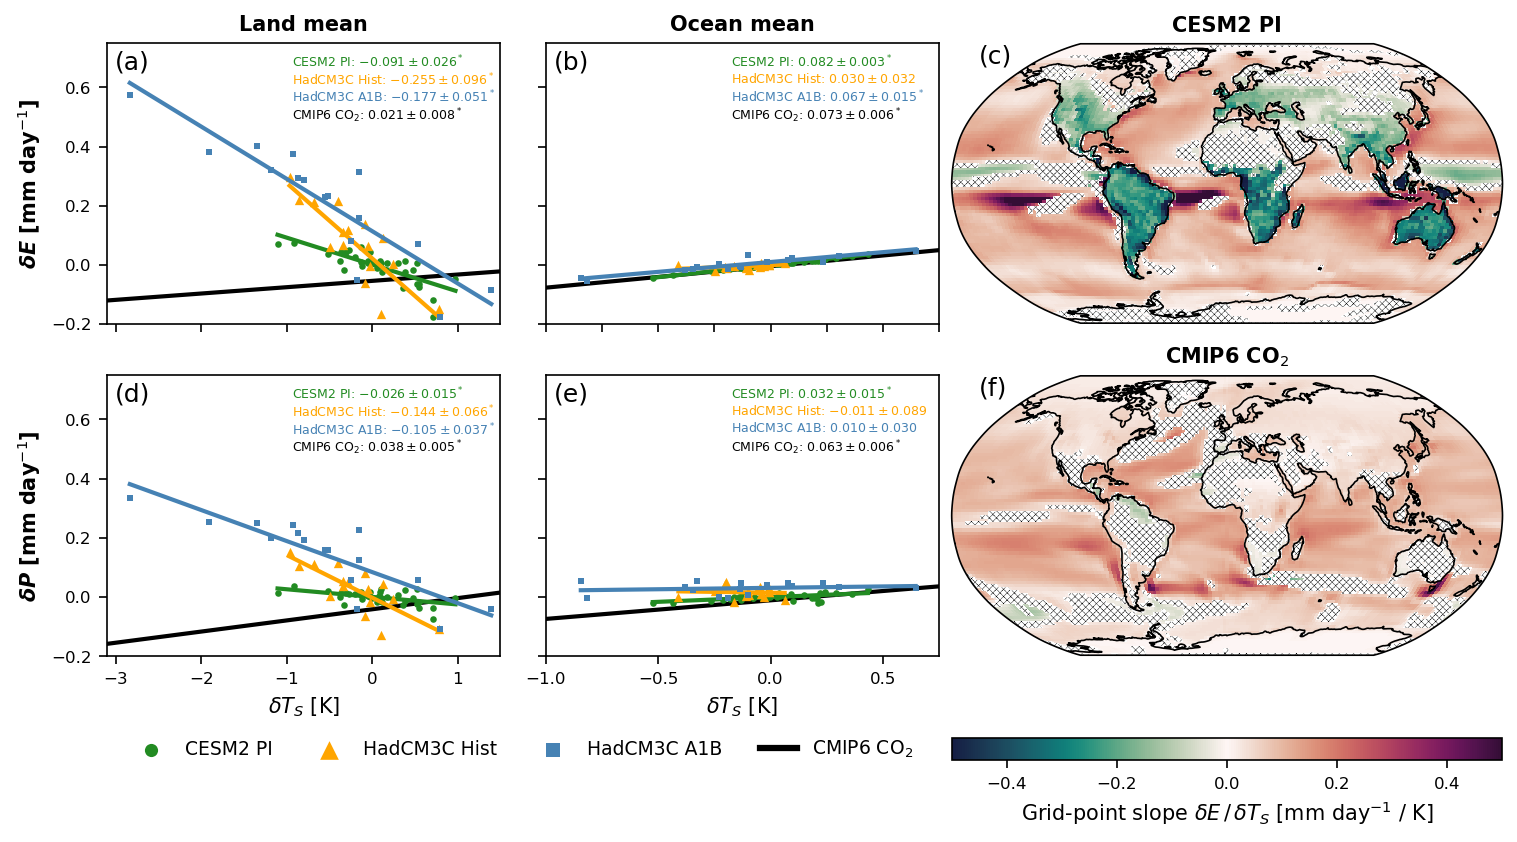

In [ ]:
xvar = 'T_S'
yvar_1 = 'ET'
yvar_2 = 'P'

# Create figure and axes
fig, axes = plt.subplots(
    3, 3, figsize=(10, 5.5),
    width_ratios=[1,1,1.4],
    height_ratios=[1,1,0.08],
    layout='constrained',
)
ax = axes.flatten()

## Create separate axis for the legend
gs = ax[6].get_gridspec()
for a in ax[6:8]:
    a.remove()
axleg = fig.add_subplot(gs[6:8])

ax[2].remove()
ax[5].remove()

ax[2] = fig.add_subplot(gs[2], projection=ccrs.Robinson())
ax[5] = fig.add_subplot(gs[5], projection=ccrs.Robinson())

## Set up axis limits
xlim = [
    [-3.1, 1.50],
    [-1.0, 0.75],
    [-3.1, 1.50],
    [-1.0, 0.75],
]
ylim = [
    [-0.20, 0.75],
    [-0.20, 0.75],
    [-0.20, 0.75],
    [-0.20, 0.75],
]

these_stats = dict(hadhst=dict(), hada1b=dict(), cesm=dict(), cmip=dict())

for i, sm in enumerate(['lm', 'om']):
    ##
    key = "cesm"
    x = cesm_delta_areamean[sm][xvar]
    
    y = cesm_delta_areamean[sm][yvar_1]
    these_stats[key][sm+"_"+yvar_1] = ppeplot.plot_scatter_regression(ax[i], x, y, ppealyz.odr_single, key, do_print=True)

    y = cesm_delta_areamean[sm][yvar_2]
    these_stats[key][sm+"_"+yvar_2] = ppeplot.plot_scatter_regression(ax[i+3], x, y, ppealyz.odr_single, key, do_print=True)

    ##
    key = "hadhst"
    x = hadhst_delta_areamean[sm][xvar]
    
    y = hadhst_delta_areamean[sm][yvar_1]
    these_stats[key][sm+"_"+yvar_1] = ppeplot.plot_scatter_regression(ax[i], x, y, ppealyz.odr_single, key, do_print=True)

    y = hadhst_delta_areamean[sm][yvar_2]
    these_stats[key][sm+"_"+yvar_2] = ppeplot.plot_scatter_regression(ax[i+3], x, y, ppealyz.odr_single, key, do_print=True)

    ##
    key = "hada1b"
    x = hada1b_delta_areamean[sm][xvar]
    
    y = hada1b_delta_areamean[sm][yvar_1]
    these_stats[key][sm+"_"+yvar_1] = ppeplot.plot_scatter_regression(ax[i], x, y, ppealyz.odr_single, key, do_print=True)

    y = hada1b_delta_areamean[sm][yvar_2]
    these_stats[key][sm+"_"+yvar_2] = ppeplot.plot_scatter_regression(ax[i+3], x, y, ppealyz.odr_single, key, do_print=True)

    ##
    key = "cmip"
    x = cmip_delta_areamean[sm][xvar]
    
    y = cmip_delta_areamean[sm][yvar_1]
    these_stats[key][sm+"_"+yvar_1] = ppeplot.plot_scatter_regression(ax[i], x, y, ppealyz.odr_single, key, do_scatter=False, do_print=True, zorder=0)

    y = cmip_delta_areamean[sm][yvar_2]
    these_stats[key][sm+"_"+yvar_2] = ppeplot.plot_scatter_regression(ax[i+3], x, y, ppealyz.odr_single, key, do_scatter=False, do_print=True, zorder=0)

## Assign axis limits and tick labels
for i, a in enumerate([ax[0], ax[1], ax[3], ax[4]]):
    a.set_ylim(ylim[i])
    a.set_xlim(xlim[i])

ax[0].set_xticklabels([])
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[4].set_yticklabels([])

ax[4].set_xticks([-1, -0.5, 0, 0.5])

## Add axis labels
ax[0].set_ylabel('$\\boldsymbol{\delta E}$ [mm day$\\boldsymbol{^{-1}}$]', fontsize=10, fontweight="bold")
ax[3].set_ylabel('$\\boldsymbol{\delta P}$ [mm day$\\boldsymbol{^{-1}}$]', fontsize=10, fontweight="bold")
ax[3].set_xlabel('$\delta T_S$ [K]', fontsize=10)
ax[4].set_xlabel('$\delta T_S$ [K]', fontsize=10)

ax[0].set_title('Land mean', fontsize=10, fontweight='bold')
ax[1].set_title('Ocean mean', fontsize=10, fontweight='bold')

## Add description of fit statistics to each subplot
def format_label_text(this_stats, key, alpha=0.05):
    ast = ""
    if this_stats["slope_p_value"] < alpha:
        ast = "^*"
    this_label = f"{ppeplot.label_dict[key]}: ${this_stats['slope']: 0.3f} \\pm {this_stats['slope_ci_halfwidth']: 0.3f}{ast}$"
    return this_label

stats_xpos = 0.47
stats_ypos = 0.775
stats_width = 0.46
stats_height = 0.25

for i, v, sm in zip([0, 1, 3, 4], ["ET", "ET", "P", "P"], ["lm", "om", "lm", "om"]):
    for j, key in enumerate(["cesm", "hadhst", "hada1b", "cmip"]):
        ax[i].text(
            stats_xpos, stats_ypos+(3-j)*(stats_height/4),
            format_label_text(these_stats[key][sm+"_"+v], key, alpha=0.05),
            fontsize=6, color=ppeplot.c_dict[key],
            ha='left', va='top',
            transform=ax[i].transAxes
        )

## Add legend
h, l = ax[0].get_legend_handles_labels()
leg = axleg.legend(h, l, ncol=4, fontsize=9, loc='center', markerscale=2)
for line in leg.get_lines():
    line.set_linewidth(3.0)
axleg.axis('off')

## Slope maps
vabs = 0.5
cmap = cmo.curl

cf1 = ppeplot.plot_slope_map(ax[2], cesm_delta[xvar], cesm_delta[yvar_1], ppealyz.odr_field, alpha_fdr=0.05, cmap=cmap, vmin=-vabs, vmax=vabs)
cf2 = ppeplot.plot_slope_map(ax[5], cmip_delta[xvar], cmip_delta[yvar_1], ppealyz.odr_field, alpha_fdr=0.05, cmap=cmap, vmin=-vabs, vmax=vabs)

ax[2].set_title(ppeplot.label_dict["cesm"], fontsize=10, fontweight='bold')
ax[5].set_title(ppeplot.label_dict["cmip"], fontsize=10, fontweight='bold')

cb = fig.colorbar(cf1, cax=ax[8], fraction=0.0225, orientation='horizontal')
cb.ax.tick_params(labelsize=8)
cb.set_ticks([-0.4, -0.2, 0, 0.2, 0.4])
cb.set_label('Grid-point slope $\delta E \\, / \\, \delta T_S$ [mm day$^{-1}$ / K]', fontsize=10)

## Add subplot numbering
for i in range(6):
    x = 0.05 if i in [2,5] else 0.02
    y = 1 if i in [2,5] else 0.975
    ax[i].text(
        x, y, f'({ppeplot.figenum[i]})',
        fontsize=12, fontweight='regular',
        ha='left', va='top',
        transform=ax[i].transAxes)

## Save figure
fig.savefig('../figures/main/fig1.pdf', bbox_inches='tight')